# Influence of life satisfaction rates on movie genre distribution
## Introduction
Historically, in many mediums and art forms, the general life Circumstances of the population had a major impact on the nature of the creative work.
e.g. The dire circumstances of people led to the rise of romanticism in the art and music space.
This project aims to find out if the general life circumstances and happiness correlates to the releases of modern media, e.g. movies.
Maybe there is some trend to escapism in times of less happiness.

## Methods


### Datasources

<!-- Describe each datasources you plan to use in a section. Use the prefic "DatasourceX" where X is the id of the datasource. -->

#### Datasource1: General happiness in european countries
* Metadata URL: https://ec.europa.eu/eurostat/databrowser/view/ILC_PW01__custom_71016/bookmark/table?lang=de&bookmarkId=59450ed9-2039-47a5-80b7-b34a948aef30
* Data URL: https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/ilc_pw01/?format=TSV&compressed=false
* Data Type: TSV

Official life satisfaction data from european countries by year.


#### Datasource2: OMDB (Open Media Database)

##### Datasource2.1: OMDB Movie Catalogue
* Metadata URL: https://www.omdb.org/en/us/content/Help:DataDownload
* Data URL: http://www.omdb.org/data/all_movies.csv.bz2
* Data Type: Zipped CSV
##### Datasource2.2: OMDB Movie Category Catalogue
* Metadata URL: https://www.omdb.org/en/us/content/Help:DataDownload
* Data URL: http://www.omdb.org/data/movie_categories.csv.bz2
* Data Type: Zipped CSV
##### Datasource2.3: OMDB Movie Category Names
* Metadata URL: https://www.omdb.org/en/us/content/Help:DataDownload
* Data URL: http://www.omdb.org/data/category_names.csv.bz2
* Data Type: Zipped CSV
##### Datasource2.4: OMDB Movie Countries
* Metadata URL: https://www.omdb.org/en/us/content/Help:DataDownload
* Data URL: http://www.omdb.org/data/movie_countries.csv.bz2
* Data Type: Zipped CSV


#### Datasource3: World Happiness Report 2023
* Metadata URL: https://worldhappiness.report/ed/2023/#appendices-and-data
* Data URL: https://happiness-report.s3.amazonaws.com/2023/DataForTable2.1WHR2023.xls
* Data Type: Excel XLS-File

Life satisfaction data for countries worldwide.


## Pipeline
### Data retrieval
Firstly, the CSV files have to be downloaded from their respective urls. The zipped data is being unpacked automatically by the pandas functions.
The CSV files for the movie information are representing a single database with multiple relations.

### Data processing
To make the Data usable for this usecase, multiple transformation steps were created:
#### on all datasets/files
- drop rows that contain null values
#### specific for EU satisfaction data
although this data might not be used excessively (afterwards, data sources that could be a better fit for the task were found), some transformation steps were necessery to make the data usable.
- for this task, only the "life satisfaction" survey results are needed. Thus, rows that don't contain the "LIFESAT" indicator are deleted.
- the column that contains the satisfaction values (measured on a scale fom 0.0 to 10.0) represents the data as string, not float. The strings can have additional characters at the end, to signalize values that are only estimated or similar. (e.g. "6.2 u"). Those kinds of values are being dropped, and the strings that remain are converted to the float datatype.
#### specific for OMDB movie data
- the movie names can sometimes create problems if they contain certain special characters. The OMDB database escapes those with "\\" characters. In earlier stages of this project, the IMDB database was used - and since that one doesn't do escaping of spechial chars, the CSV interpretation was a lot more difficult.
- the OMDb movie CSVs represent a single database, and each relation is in a separate CSV file. To save space and minimize redundancy, this structure is being kept mostly intact in the pipeline process and only small tweaks are being done.
- Null values are represented as a char "N" in the CSV. These values are converted to null before the "dropping NULL values" step.

### Save to SQL
At last, all the data is stored into a single SQLite database. From there, the analysis can begin.

## Results

### Preparation

#### Python imports

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy as sal

#### Helper functions
Now, let's create some functions that load the data from the SQLite file and plot them on the screen:

In [11]:
def plot_movie_genres(genres, country_code):
    for i in range(len(genres)):
        SQLString = f"""
        SELECT COUNT(DISTINCT movies.name) as "amount of movies", CAST(STRFTIME('%Y',movies.date) AS INTEGER) AS year FROM movies
        JOIN movie_categories ON id = movie_categories.movie_id
        JOIN movie_category_names ON movie_categories.category_id = movie_category_names.category_id
        JOIN movie_countries ON movie_countries.movie_id = movies.id
        WHERE movie_category_names.name = "{genres[i]}" AND year>2004 AND movie_countries.country_code = "{country_code}"
        GROUP BY YEAR
        ORDER BY YEAR
        """
        df_genre = pd.read_sql(SQLString, engine, parse_dates=["movies.date"])
        df_genre = df_genre.dropna()
        x_genre = df_genre['year']
        y_genre = df_genre['amount of movies']
        thisPlot = movies[0].plot(x_genre, y_genre, label=f'{genres[i]}')
        plt.xticks(np.arange(min(x_genre), max(x_genre)+1, 2))
        movies[0].legend()


In [12]:
def plot_life_ladder(country_name):
    SQLString = f"""
    SELECT * FROM life_ladder
    WHERE "Country name" = "{country_name}"
    """
    df_ladder = pd.read_sql(SQLString, engine)
    movies[1].plot(df_ladder['year'], df_ladder['Life Ladder'])

### Analysis
#### Step-wise tweaking of data representation
Since everything is prepared now, let's dive in and plot the amount of different movie genres (from movies released in germany) alongside the reported happiness survey results in the same time span.

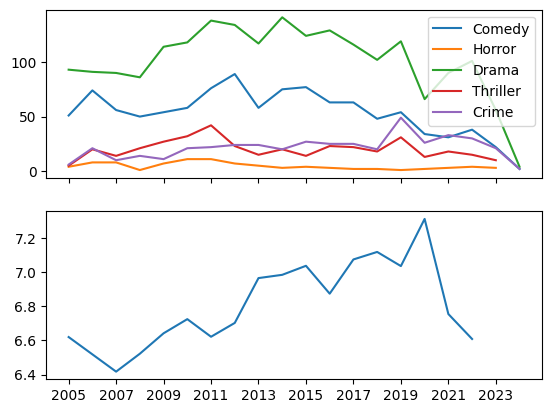

In [13]:
 engine = sal.create_engine('sqlite:///../data/projectdata.sqlite')
 fig, movies = plt.subplots(2, sharex=True)
 plot_movie_genres(['Comedy', 'Horror', 'Drama', 'Thriller', 'Crime'], 'DE')
 plot_life_ladder('Germany')

So at first glance it is difficult to see a relation between those two graphs.
Now, whar has to be taken into consideration are two things:
1. The total amount of movies released per year is not constant. Maybe it makes sense to use the percentage of movies of the different genres instead.
2. When looking at the graphs, changes in the life satisfaction could only take effect in the upper graphs after some time.

So let's use the percentage instead:

In [14]:
def plot_movie_genres_percentages(genres, country_code):
    for i in range(len(genres)):
        SQLString = f"""
        SELECT COUNT(DISTINCT movies.name) as "amount of movies", CAST(STRFTIME('%Y',movies.date) AS INTEGER) AS year FROM movies
        JOIN movie_categories ON id = movie_categories.movie_id
        JOIN movie_category_names ON movie_categories.category_id = movie_category_names.category_id
        JOIN movie_countries ON movie_countries.movie_id = movies.id
        WHERE movie_category_names.name = "{genres[i]}" AND year>2004 AND movie_countries.country_code = "{country_code}" AND year < 2023
        GROUP BY YEAR
        ORDER BY YEAR
        """
        SQLString_total_amount = F"""
        SELECT COUNT(*) AS total, CAST(STRFTIME('%Y',movies.date) AS INTEGER) AS year FROM movies, movie_countries
        WHERE movie_countries.movie_id = movies.id AND year>2004 AND year < 2023
        GROUP BY YEAR
        """
        df_genre = pd.read_sql(SQLString, engine, parse_dates=["movies.date"])
        df_genre_total = pd.read_sql(SQLString_total_amount, engine, parse_dates=["movies.date"])
        x_genre = [i for i in range(2005, 2023)]
        y_genre = df_genre['amount of movies']
        y_genre_total = df_genre_total['total']
        y = np.divide(y_genre, y_genre_total)
        thisPlot = movies[0].plot(x_genre, y, label=f'{genres[i]}')
        plt.xticks(np.arange(min(x_genre), max(x_genre)+1, 2))
        movies[0].legend()


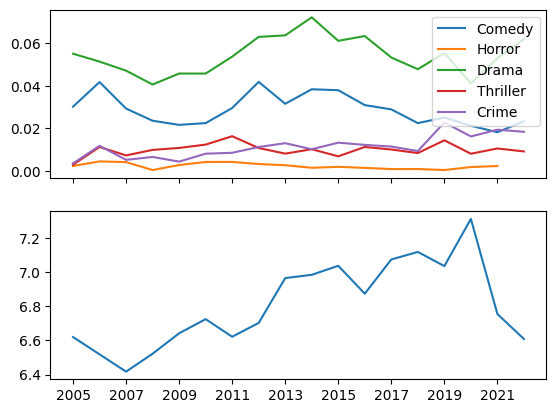

In [15]:
engine = sal.create_engine('sqlite:///../data/projectdata.sqlite')
fig, movies = plt.subplots(2, sharex=True)
plot_movie_genres_percentages(['Comedy', 'Horror', 'Drama', 'Thriller', 'Crime'], 'DE')
plot_life_ladder('Germany')

Now, for comparison, let's also look at the situation in the US for comparison.

#### absolute numbers

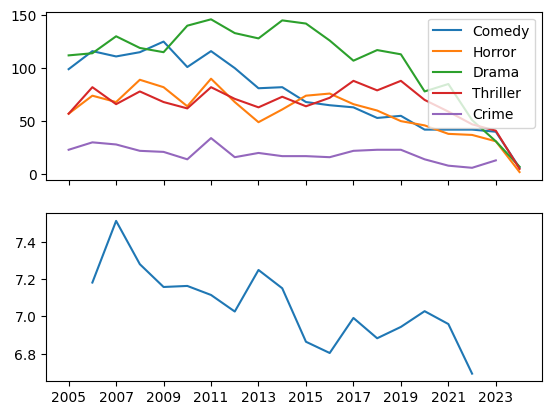

In [19]:
 fig, movies = plt.subplots(2, sharex=True)
 plot_movie_genres(['Comedy', 'Horror', 'Drama', 'Thriller', 'Crime'], 'US')
 plot_life_ladder('United States')

Now something seems to be off: The total amount of movies doesn't seem too much higher in the US.
This could be caused by the movie dataset and the genre names being too specific, maybe just my assumption that there are more US movies was wrong. But since we want the graph to be easily readable we just go for it for now. We take these data as representations for genres that serve different types of moods and look at the differences.

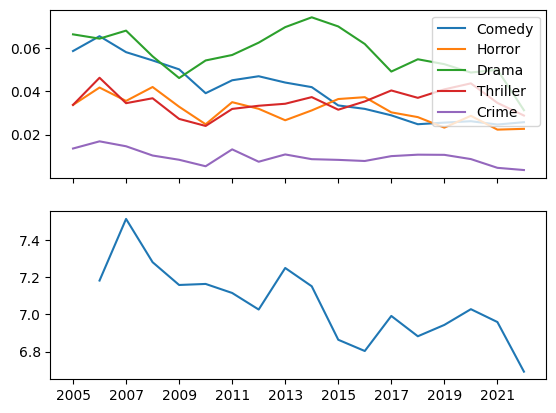

In [17]:
fig, movies = plt.subplots(2, sharex=True)
plot_movie_genres_percentages(['Comedy', 'Horror', 'Drama', 'Thriller', 'Crime'], 'US')
plot_life_ladder('United States')

### Conclusions

Firstly, more reliable data on the happiness and life satisfaction of people would be helpful to see possible connections over a bigger time span. Unfortunately, there are not many reliable data sources openly available, so we have to go with going back to 2005 at most.


So if you look at those graphs, a few things come to mind. If you only look at the genre percentages, the Drama and Comedy genres seem to be affected more over time compared to the other ones. This seems to be the case in Germany as well as in the US.
But if you want to see a correlation between the happiness data and different movie genres, there is not much to observe. In the US, the drama genre seems to get less popular with lower life satisfaction rates, but in Germany, there is no clear trend visible. 

Of course, this could have multiple reasons. Maybe, there is just not a great connection between the two things.
It also could be cultural differences, so changes in society just translate diffently into media depending on the country. In general, you could try to see some trends independently for different genres and time spans, but it's quite clear that general statements on the theory are difficult to be done.

What also catches the eye is the visible decrease in movie releases in general shortly after the corona pandemic started. Of course, the pandemic also had effects on the happiness of people all over the world, but according to many reports in media, this was at least partly caused by more economic reasons:
Many movies were deleyed in that time period because of problems in the filming process and concerns about viewer rates.

It is no big surprise that it's difficult to get some hard evidence for the theory. Possibly there are ways to get more clear results on this topic if you take some complex considerations into the equation, but for this report, we have to accept that at least the initial question could not really be answered with 'yes'.